<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>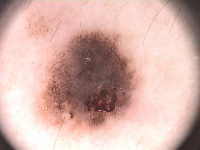</td><td>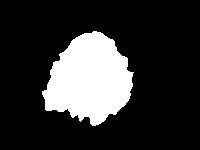</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# ! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
# ! wget https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

! gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar
#альтернативная ссылка на данные: https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 217MB/s]


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

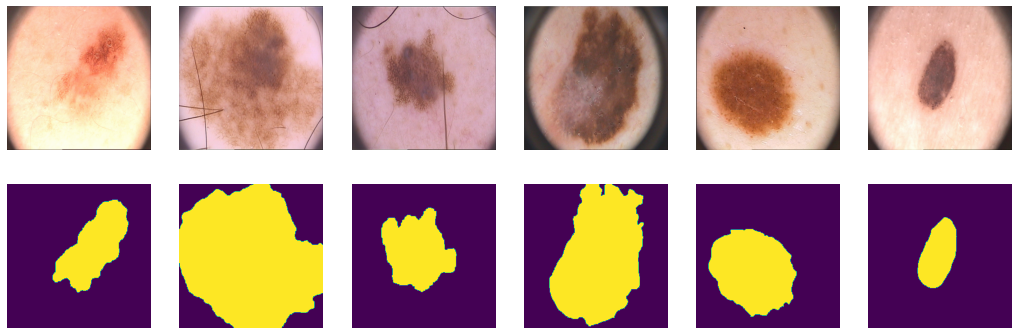

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

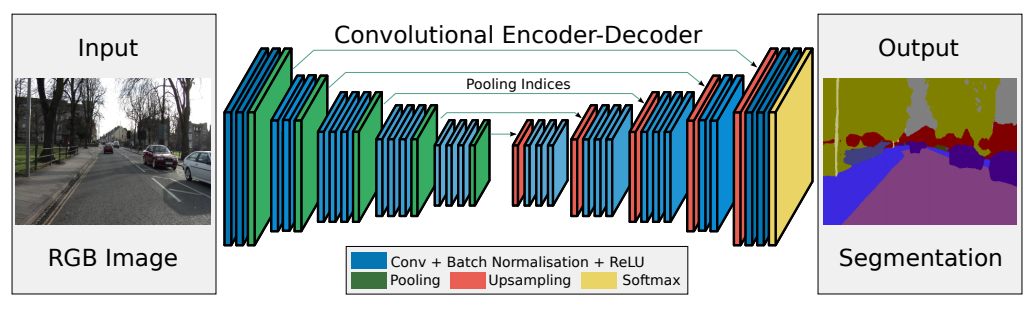

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
import math

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
# model=models.vgg16()

In [ ]:
from torchvision.models.densenet import densenet121
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True) # 128 -> 64
       
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True) # 64 -> 32
       
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.bottleneck_maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
        self.bottleneck_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        
        self.bottleneck_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        ) 

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0, e0_ind = self.pool0(self.enc_conv0(x))
        e1, e1_ind = self.pool1(self.enc_conv1(e0))
        e2, e2_ind = self.pool2(self.enc_conv2(e1))
        e3, e3_ind = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b1, b1_ind = self.bottleneck_maxpool(self.bottleneck_conv1(e3))
        b2 = self.bottleneck_unpool(b1, b1_ind)
        b21 = self.bottleneck_conv2(b2)
        
        # decoder
        d0 = self.upsample0(b21, e3_ind)
        d01 = self.dec_conv0(d0)
        d1 = self.upsample1(d01, e2_ind)
        d11 = self.dec_conv1(d1)
        d2 = self.upsample2(d11, e1_ind)
        d21 = self.dec_conv2(d2)
        d3 = self.upsample3(d21, e0_ind)
        d31 = self.dec_conv3(d3)

        return d31

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
from traitlets.traitlets import Union
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    x = y_pred.to(device)
    z = y_real.to(device)
    p = x>0
    loss = p * x - x * z + torch.log(1 + torch.exp(-abs(x)))
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = (torch.sigmoid(model(X_batch))>0.5).type(torch.int64).detach()
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val, scores_list, losses_list):
    X_val, Y_val = next(iter(data_val))
    avg_loss = 0
    current_loss_valid = 0
    current_score_train = 0
    current_score_valid = 0
    score_train = []
    score_valid = []
    loss_valid = []
    loss_train = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        print('loss_train: %f' % avg_loss)
        print('loss_valid: %f' % current_loss_valid)
        print('score_train: %f' % current_score_train)
        print('score_valid: %f' % current_score_valid)

        avg_loss = 0
        model.train()  # train mode
        
        for X_batch, Y_batch in data_tr:
            
            # data to device
            X_val = X_val.to(device)
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)# forward-pass
            current_loss = loss
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        scheduler.step()    
        loss_train.append(avg_loss)
        current_score_train = score_model(model, iou_pytorch, data_tr)
        score_train.append(current_score_train)
        toc = time()

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            current_loss_valid = 0
            Y_hat = (torch.sigmoid(model(X_val))>0.5).type(torch.int64).detach().to('cpu') # detach and put into cpu
            for X_val1, Y_val1 in data_val:
                X_val1, Y_val1 = X_val1.to(device), Y_val1.to(device)
                logit = model(X_val1)
                moment_loss_valid = loss_fn(logit, Y_val1)
                current_loss_valid += moment_loss_valid / len(data_val)
            current_score_valid = score_model(model, iou_pytorch, data_val)
            loss_valid.append(current_loss_valid)
            score_valid.append(current_score_valid)
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].to('cpu').numpy(), 0, 3), cmap='gray')
            plt.title('X_val')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output_network')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Y_val')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        scores_list.append(score_model(model, iou_pytorch, data_val)) # добавим значения скора и лосса для последующей печати на графике
        losses_list.append(avg_loss)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), loss_train, label='Loss_train')
    plt.plot(range(epochs), loss_valid, label='Loss_valid')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")


    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), score_train, label='score_train')
    plt.plot(range(epochs), score_valid, label='score_valid')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("score")
    plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = (torch.sigmoid(model(X_batch))>0.5).type(torch.int64).detach()
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
# model = SegNet().to(device) # Если нужно загрузить без обучения
# model.load_state_dict(torch.load('SegNet_bce'))

In [ ]:
device

'cuda'

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100 # будет работать для всех моделей

In [ ]:
segnet_bce_scores = []
segnet_bce_loss = []

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

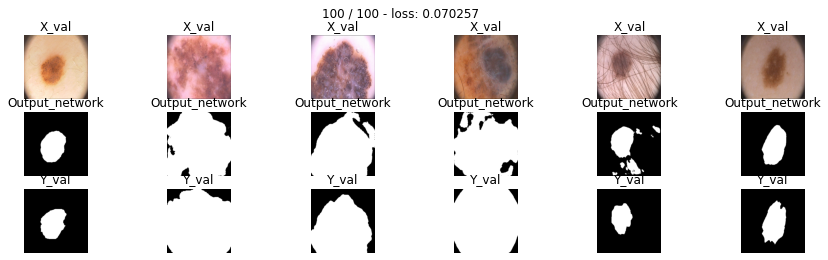

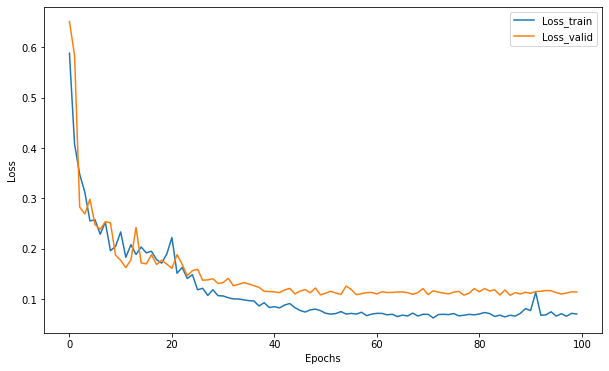

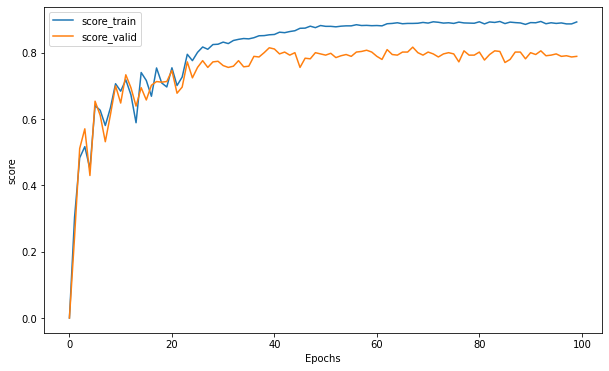

In [ ]:
# optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer, exp_lr_scheduler, bce_loss, max_epochs, data_tr, data_val, segnet_bce_scores, segnet_bce_loss)

In [ ]:
segnet_bce_scor_test = score_model(model, iou_pytorch, data_ts)
score_model(model, iou_pytorch, data_val)

0.7962963316175673

In [ ]:
torch.save(model.state_dict(), 'SegNet_bce') #Запишем результаты обучения модели

In [ ]:
! ls

PH2Dataset  PH2Dataset.rar  sample_data  SegNet_bce


Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real): 
    smooth = 1
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
        
    intersection = (y_pred * y_real).sum()                            
    dice = (2.*intersection + smooth)/(y_pred.sum() + y_real.sum() + smooth)
    
    return 1 - dice

Проводим тестирование:

In [ ]:
# model_dice = SegNet().to(device) # Если нужно загрузить без обучения
# model.load_state_dict(torch.load('SegNet_dice'))

In [ ]:
model_dice = SegNet().to(device)

In [ ]:
segnet_dice_scores = []
segnet_dice_loss = []

In [ ]:
optimizer = torch.optim.AdamW(model_dice.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

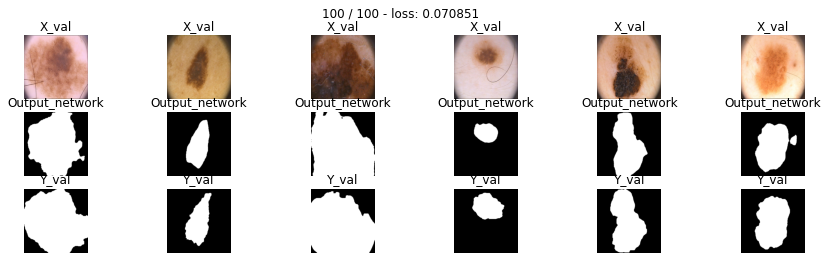

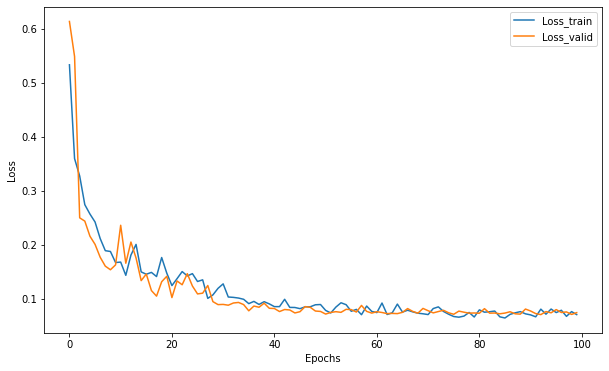

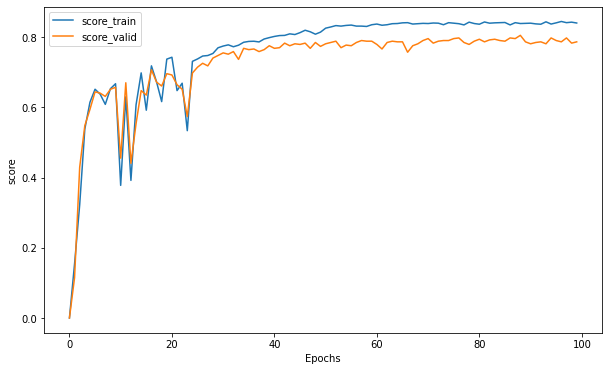

In [ ]:
train(model_dice, optimizer, exp_lr_scheduler, dice_loss, max_epochs, data_tr, data_val, segnet_dice_scores, segnet_dice_loss)

In [ ]:
segnet_dice_scor_test = score_model(model_dice, iou_pytorch, data_ts)
score_model(model_dice, iou_pytorch, data_val)

0.7870370811886258

In [ ]:
torch.save(model_dice.state_dict(), 'SegNet_dice')

In [ ]:
!ls

PH2Dataset  PH2Dataset.rar  sample_data  SegNet_bce  SegNet_dice


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    bce = bce_loss(y_pred, y_real)
    bce_exp = torch.exp(-bce)
    your_loss = 0.8 * (1 - bce_exp) ** gamma * bce
    # your_loss = eps * (1 - bce_exp) ** gamma * bce
    return your_loss

In [ ]:
model_focal = SegNet().to(device)

In [ ]:
segnet_focal_scores = []
segnet_focal_loss = []

In [ ]:
optimizer = torch.optim.AdamW(model_focal.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

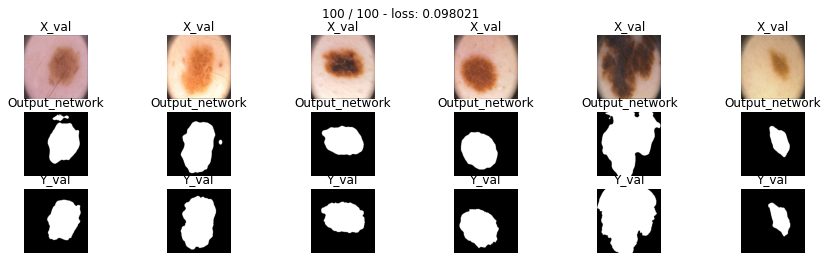

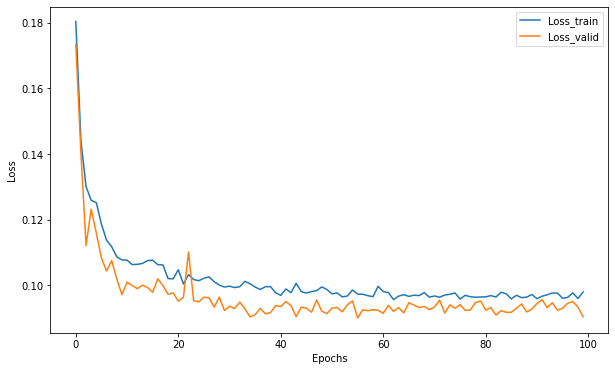

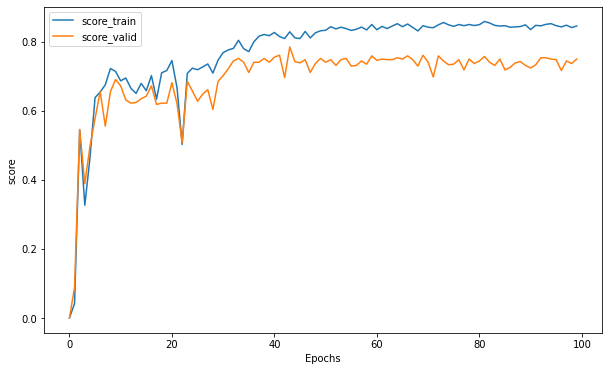

In [ ]:
train(model_focal, optimizer, exp_lr_scheduler, focal_loss, max_epochs, data_tr, data_val, segnet_focal_scores, segnet_focal_loss)

In [ ]:
segnet_focal_scor_test = score_model(model_focal, iou_pytorch, data_ts)
score_model(model_focal, iou_pytorch, data_val)

0.727777812216017

In [ ]:
torch.save(model_focal.state_dict(), 'SegNet_focal')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

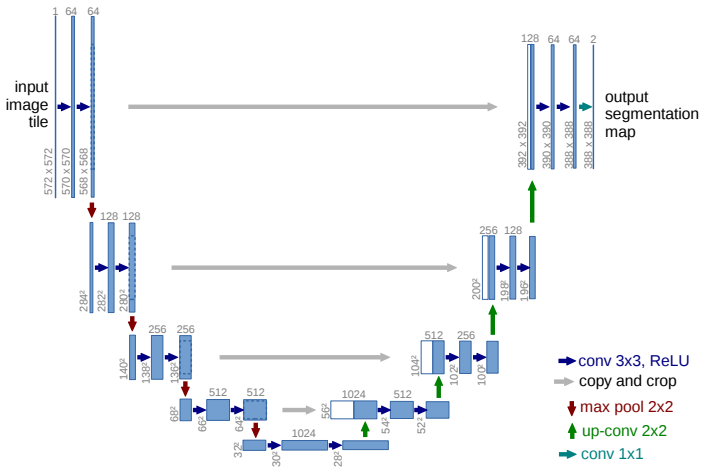

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)


Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 128 -> 256

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.dec_conv_fin = nn.Conv2d(32, 1, kernel_size=1, stride=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_pool = self.pool0(e0)
        e1 = self.enc_conv1(e0_pool)
        e1_pool = self.pool1(e1)
        e2 = self.enc_conv2(e1_pool)
        e2_pool = self.pool2(e2)
        e3 = self.enc_conv3(e2_pool)
        e3_pool = self.pool3(e3)
 
        # bottleneck
        b = self.bottleneck_conv(e3_pool)

        # decoder
        d0 = self.upsample0(b)
        d0_cat = torch.cat((d0, e3), 1)
        d0_conv = self.dec_conv0(d0_cat)
        d1 = self.upsample1(d0_conv)
        d1_cat = torch.cat((d1, e2), 1)
        d1_conv = self.dec_conv1(d1_cat)
        d2 = self.upsample2(d1_conv)
        d2_cat = torch.cat((d2, e1), 1)
        d2_conv = self.dec_conv2(d2_cat)
        d3 = self.upsample3(d2_conv)
        d3_cat = torch.cat((d3, e0), 1)
        d3_conv = self.dec_conv3(d3_cat)
        d_fin = self.dec_conv_fin(d3_conv)  # no activation

        return d_fin

In [ ]:
unet_model_bce = UNet().to(device)

In [ ]:
unet_bce_scores_list = []
unet_bce_loss_list = []

In [ ]:
optimizer = torch.optim.AdamW(unet_model_bce.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

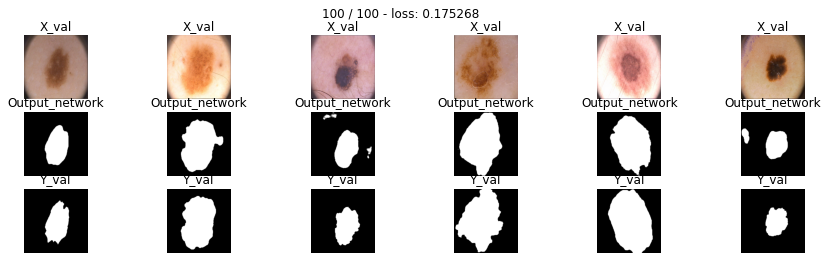

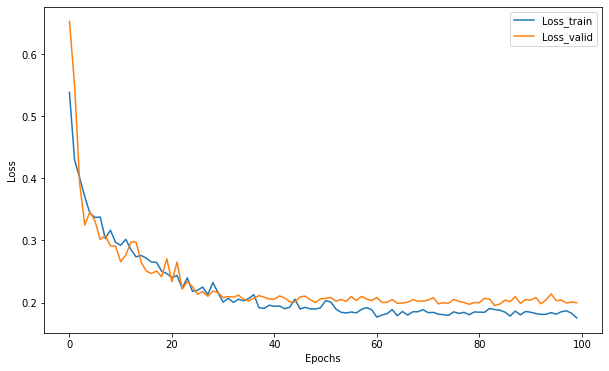

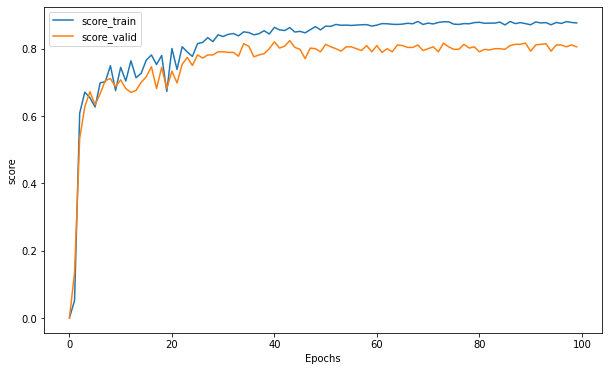

In [ ]:
train(unet_model_bce, optimizer, exp_lr_scheduler, bce_loss, max_epochs, data_tr, data_val, unet_bce_scores_list, unet_bce_loss_list)

In [ ]:
unet_bce_scor_test = score_model(unet_model_bce, iou_pytorch, data_ts)
score_model(unet_model_bce, iou_pytorch, data_val)

0.7870370613204108

In [ ]:
torch.save(unet_model_bce.state_dict(), 'Unet_bce')

Теперь модель UNet с DiceLoss

In [ ]:
unet_model_dice = UNet().to(device)

In [ ]:
unet_dice_scores_list = []
unet_dice_loss_list = []

In [ ]:
optimizer = torch.optim.AdamW(unet_model_dice.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

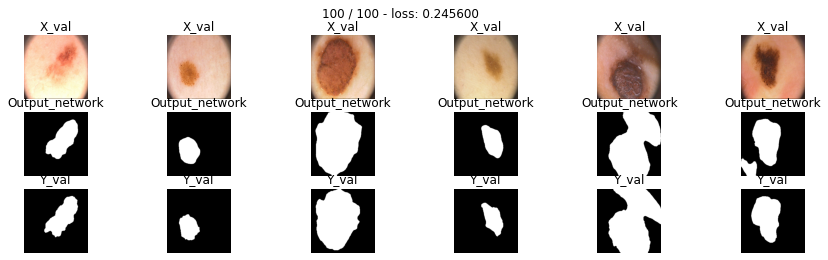

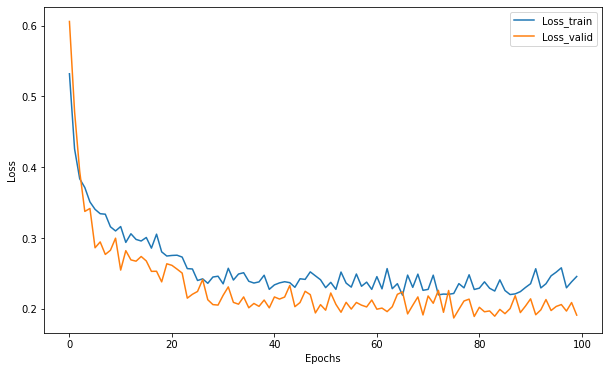

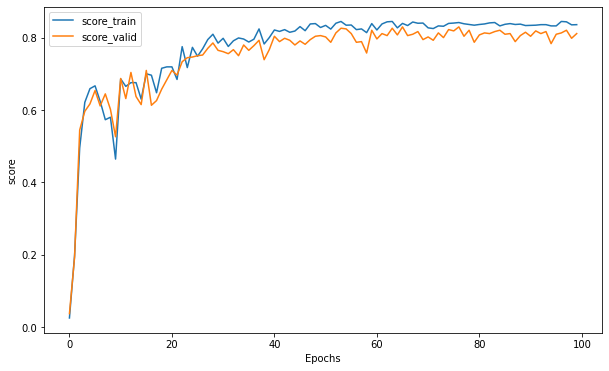

In [ ]:
train(unet_model_dice, optimizer, exp_lr_scheduler, dice_loss, max_epochs, data_tr, data_val, unet_dice_scores_list, unet_dice_loss_list)

In [ ]:
unet_dice_scor_test = score_model(unet_model_dice, iou_pytorch, data_ts)
score_model(unet_model_dice, iou_pytorch, data_val)

0.8074074453777738

In [ ]:
torch.save(unet_model_dice.state_dict(), 'Unet_dice')

Теперь проверьте модель UNet c функцией потерь FocalLoss. 

In [ ]:
unet_model_focal = UNet().to(device)

In [ ]:
unet_focal_scores_list = []
unet_focal_loss_list = []

In [ ]:
optimizer = torch.optim.AdamW(unet_model_focal.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

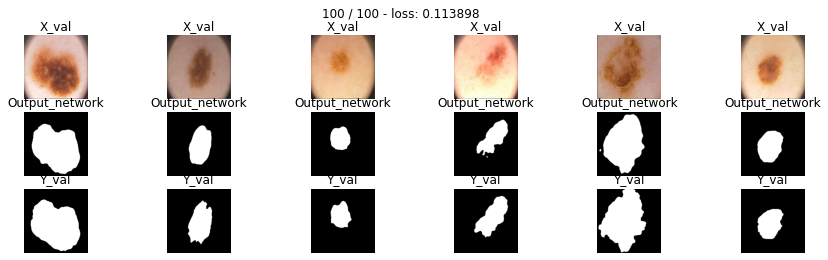

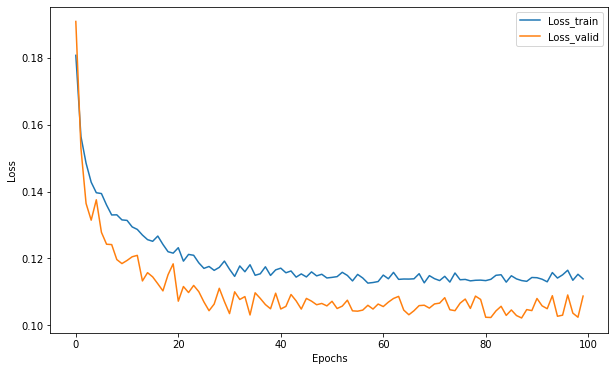

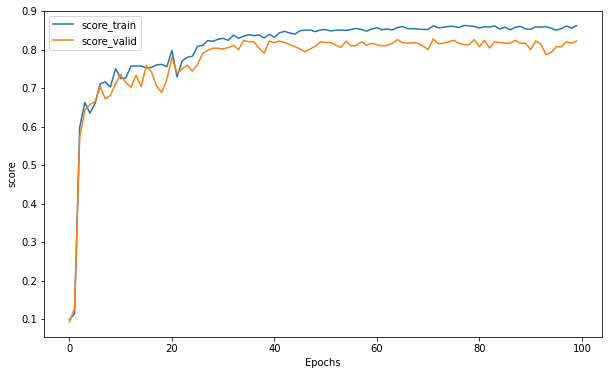

In [ ]:
train(unet_model_focal, optimizer, exp_lr_scheduler, focal_loss, max_epochs, data_tr, data_val, unet_focal_scores_list, unet_focal_loss_list)

In [ ]:
unet_focal_scor_test = score_model(unet_model_focal, iou_pytorch, data_ts)
score_model(unet_model_focal, iou_pytorch, data_val)

0.8148148457209269

In [ ]:
torch.save(unet_model_focal.state_dict(), 'Unet_focal')

Сделайте вывод, какая из моделей лучше.

Посмотрим какой из вариантов моделей и с какой функцией потерь оказалась наиболее эффективной по итогу 100 эпох обучения:

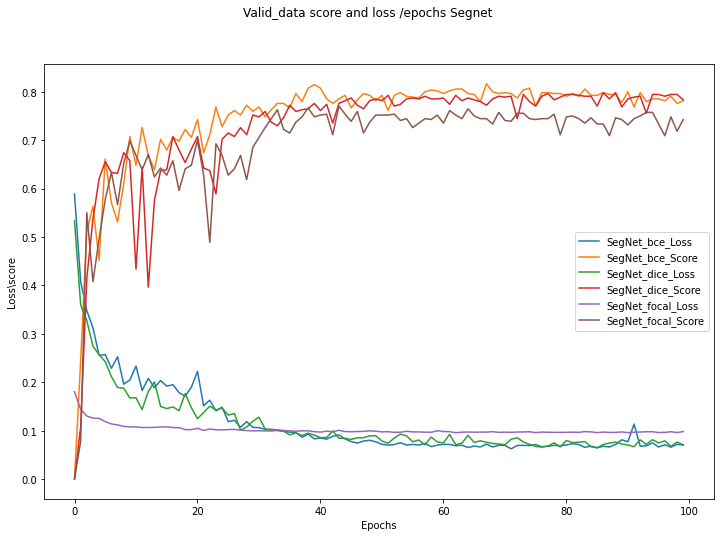

In [ ]:
epochs = max_epochs
plt.figure(figsize=(12, 8))
plt.suptitle('Valid_data score and loss /epochs Segnet')
plt.plot(range(epochs), segnet_bce_loss, label='SegNet_bce_Loss')
plt.plot(range(epochs), segnet_bce_scores, label='SegNet_bce_Score')
plt.plot(range(epochs), segnet_dice_loss, label='SegNet_dice_Loss')
plt.plot(range(epochs), segnet_dice_scores, label='SegNet_dice_Score')
plt.plot(range(epochs), segnet_focal_loss, label='SegNet_focal_Loss')
plt.plot(range(epochs), segnet_focal_scores, label='SegNet_focal_Score')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss\score")
plt.show()

Значения как скора, так и функции loss на валидационной выборке при использовании BCE и Dice лоссов очень близки. Функция потерь Focal при работе с моделью SegNet показала наихудший результат.

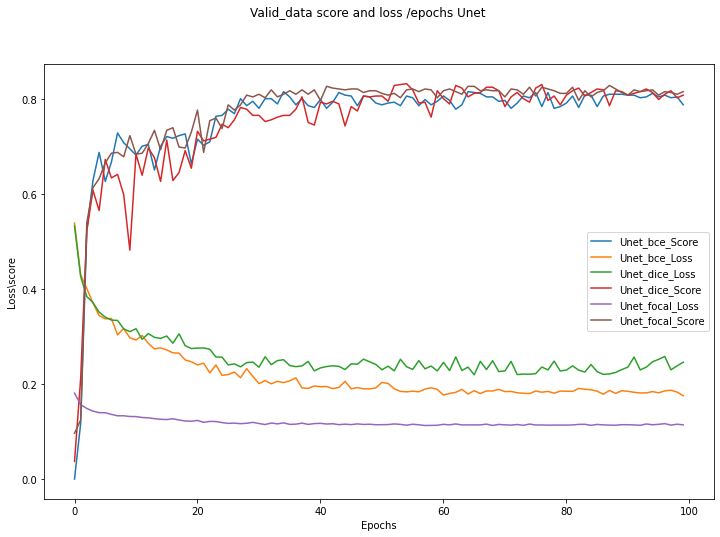

In [ ]:
epochs = max_epochs
plt.figure(figsize=(12, 8))
plt.suptitle('Valid_data score and loss /epochs Unet')
plt.plot(range(epochs), unet_bce_scores_list, label='Unet_bce_Score')
plt.plot(range(epochs), unet_bce_loss_list, label='Unet_bce_Loss')
plt.plot(range(epochs), unet_dice_loss_list, label='Unet_dice_Loss')
plt.plot(range(epochs), unet_dice_scores_list, label='Unet_dice_Score')
plt.plot(range(epochs), unet_focal_loss_list, label='Unet_focal_Loss')
plt.plot(range(epochs), unet_focal_scores_list, label='Unet_focal_Score')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss\score")
plt.show()

Значения функции лосс на валидационной выборке отличаются существенно, но при этом поведение скора при всех функциях потерь очень близко. Выделить лучший результат функции потерь на валидационной выборке не представляется возможным.

No handles with labels found to put in legend.


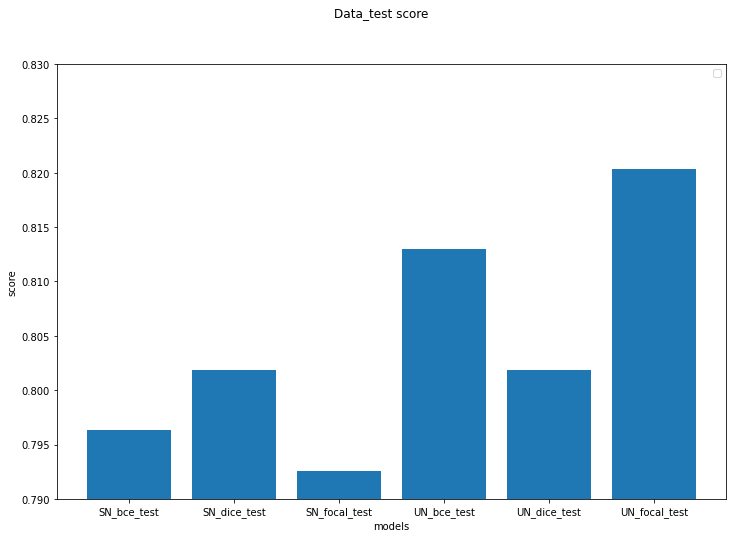

In [ ]:
plt.figure(figsize=(12, 8))
plt.suptitle('Data_test score')
line = [segnet_bce_scor_test, segnet_dice_scor_test, segnet_focal_scor_test, unet_bce_scor_test, unet_dice_scor_test, unet_focal_scor_test]
label = ['SN_bce_test','SN_dice_test','SN_focal_test','UN_bce_test','UN_dice_test','UN_focal_test']
plt.bar(label, line)
plt.legend()
plt.xlabel("models")
plt.ylabel("score")
plt.ylim([0.79, 0.83])
plt.show()

Результаты на тестовой выборке представлены выше. UNet, в общем виде, выглядит как более предпочтительная модель, в сравнении с SegNet. Исключение составляет использование Dice-Loss. В обоих случаях модели показали близкий к одинаковому результат. Наиболее успешной является UNet модель с Focal-Loss. Хотя стоит отметить, что разница между худшей моделью и лучшей лежит всего лишь в пределах 0,03. 

# Отчёт
Итак. Мною были реализованы архитектуры двух моделей нейронных сетей: SegNet, отличительной особенностью которой является использование индексирования при макспуллинге и анпуллинге; U-Net, отличающуюся от предшственницы использованием skip-connetion, но уже без индексации пуллинговых слоёв. 
За основу энкодера SegNet были взяты первые слои сети VGG-16. Декодер был написан по схеме, предложенной в соответсвцующем разделе. 
U-Net был немного переработан в связи с тем, что исходные изображения имели несколько отличное от задуманного авторами сети. Было уменьшено число выходных каналов.

Далее, был написан код для трёх функций потерь BCE, Dice и Focal. Реализация кода была сделана с помощью гугления, а так же активному социальному взаимодействию. Последний, к слову, оказал наибольший эффект на достижение результата.

При реализации функций потреь пришлось узнать про множество подводных камней, например, что разным функйциям нужен разный вход. Где-то чистый тензор выхода модели, где-то пропущенный через сигмоиду. Это было интересно!
Правильной идеей оказалось сравнить выходы лосс-функций с таковыми у уже реализованных в библиотеке. Например наш BCE и nn.BCEWithLogitsLoss().
После нескольких десятков попыток, модели наконец стали обучаться и выдавать адекватные предсказания, чему я был несомненно рад! Но, оказалось, что предложенный авторами ноутбука оптимизатор был не самым удачным решением. Для начал я сменил его на AdamW. Это улучшило результаты, но не слишком. Следующим шагом было уменьшение лёрнинг рейта на порядок. А вот это уже дало приличный прирост к скору. После применил scheduler. Результат вырос, но уже менее значительно. 

Сама функция train была доработана, добавил списки для добавления и хранения в них результатов лосса и скора во время обучения. Вывел на экран эталонную сегментацию - это позволило лучше визуально наблюдать и контролировать обучение модели. Так же добавил отображение метрик во время обучения, а не только в его конце. Это чуть замедлило процесс обучения, но не критично. Зато не было нужды ждать обучения, что бы увидеть какие-то отклонения от ожидаемого поведения модели. Да, так же, число эпох было увеличино до 100. Это может показаться излишним, но хотелось увидеть когда начнётся переобучение. К слову, оно обнаружено не было. Но и улучшения качества модели не наблюдалось после примерно 50-60 эпох. Как график лосса так и скора к этим числам эпохи выходили на плато и практически не изменялись. Да, это связано в первую очередь с уменьшением лернинг рейта, но и без него модель не улучшала свои качества. 

Результаты обучения всех 6 моделей (SegNet и U-Net по 3 функции лосс на каждую) представлены на графиках выше отчёта. Сделать однозначные выводы мне сложно, ввиду малого опыта. Но личное мнение таково - U-Net интереснее, её реализация как будто проще, обучение происходит почти в 3 раза быстрее. Думаю, если использовать более обширные датасеты, то этот фактор может быть очень важен. Ну и к тому же лучший результат, как раз показала эта сеть с функцией потерь - Focal Loss. 